In [ ]:
import os, sys
from pathlib import Path
import shutil
import zipfile
from tqdm import tqdm
from google.colab import drive
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Subset
import torch, math
import torch.nn as nn
import torch.nn.functional as F
from torchsummary import summary
from google.colab import drive
import numpy as np


# download Git repo
repo = 'forget'
if os.path.isdir(repo):
  shutil.rmtree(repo)
!git clone https://github.com/pinakm9/forget.git
# add modules folder to Python's search path
script_dir = Path(os.path.dirname(os.path.abspath('')))
sys.path.insert(0, '/content/' + repo + '/modules')
sys.path.insert(0, '/content/' + repo + '/modules/celeba_male')


# load custom modules
import vae_train as vt
import vae_ortho as vo
import vae_surgery as vs
import vae_os as vos
import vae_ascent as va
import vae_ad as vad
import classifier as cl
import batch as bt
import utility as ut
from vae import VAE
import datapipe


# set general parameters
device = ut.get_device()
celeba_folder = "/content/CelebA"
experiment_folder = "/content/CelebA-Experiments"
num_fid_samples = 25000
fid_batch_size = 256
num_experiments = 10
drive_root = '/content/drive/MyDrive/Pinak/forget/CelebA'


# Mount Google Drive and copy data folder
drive.mount('/content/drive')


# Download and unzip the CelebA data
zip_path = f'{drive_root}/img_align_celeba.zip'
if not os.path.exists(f'{celeba_folder}/dataset'):
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(f'{celeba_folder}/dataset')

# Transfer metadata
try:
  shutil.copytree(f'{drive_root}/cnn', f'{celeba_folder}/cnn')
  shutil.copytree(f'{drive_root}/vae', f'{celeba_folder}/vae')
  shutil.copy(f'{drive_root}/list_attr_celeba.csv', f'{celeba_folder}/dataset/list_attr_celeba.csv')
except:
  print("Metadata already copied")

Cloning into 'forget'...
remote: Enumerating objects: 811, done.
remote: Counting objects: 100% (410/410), done.
remote: Compressing objects: 100% (252/252), done.
remote: Total 811 (delta 262), reused 277 (delta 142), pack-reused 401 (from 1)
Receiving objects: 100% (811/811), 88.00 MiB | 45.53 MiB/s, done.
Resolving deltas: 100% (488/488), done.
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Metadata already copied


In [ ]:
# set more experiment parameters
params = {
    "model": f"{celeba_folder}/vae/vae_200.pth",
    "latent_dim": 512,
    "num_steps": 50,
    "batch_size": 128,
    "log_interval": 1,
    "collect_interval": "epoch",
    "save_steps": "epoch",
    "all_classes": [0, 1],
    "forget_class": 1,
    "classifier_path": f"{celeba_folder}/cnn/cnn_10.pth",
    "kl_weight": 1,
    "total_duration": None,
    "data_path": f'{celeba_folder}/dataset',
    "max_data": None
}

dataloader = datapipe.CelebAData(img_path=f'{celeba_folder}/dataset').get_dataloader(params['batch_size'])
num_epochs = np.ceil(len(dataloader) / params['num_steps'])
print(f"Total epochs = {num_epochs}, steps per epoch = {len(dataloader)}, data size = {params['batch_size']*len(dataloader)}")

Total epochs = 32.0, steps per epoch = 1582, data size = 202496


In [ ]:
try:
  shutil.rmtree(experiment_folder)
except:
  pass
os.mkdir(experiment_folder)

**Batch Experiments: A**

In [ ]:
train_kwargs = params | {"num_steps": 500, "uniformity_weight": 0e3}
train_kwargs["folder"] = f"{experiment_folder}/vae-a"
be = bt.BatchExperiment(va.train, train_kwargs, num_experiments)
be.run()
# torch.cuda.empty_cache()
be.fid(num_fid_samples, device, fid_batch_size)
be.summarize(num_fid_samples=num_fid_samples, batch_size=256)

Epochs:   0%|          | 0/1 [00:00<?, ?it/s]

**Batch Experiments: AD**

In [ ]:
train_kwargs = params | {"num_steps": 500, "uniformity_weight": 0e3}
train_kwargs["folder"] = f"{experiment_folder}/vae-ad"
be = bt.BatchExperiment(vad.train, train_kwargs, num_experiments)
be.run()
be.fid(num_fid_samples, device, fid_batch_size)
be.summarize(num_fid_samples=num_fid_samples, batch_size=fid_batch_size)

**Batch Experiments: S**

In [ ]:
train_kwargs = params | {"num_steps": 500, "uniformity_weight": 0e3}
train_kwargs["folder"] = f"{experiment_folder}/vae-s"
be = bt.BatchExperiment(vs.train, train_kwargs, num_experiments)
# be.run()
be.fid(num_fid_samples, device, fid_batch_size)
be.summarize(num_fid_samples=num_fid_samples, batch_size=fid_batch_size)

**Batch Experiments: Shat**

In [ ]:
train_kwargs = params | {"uniformity_weight": 1e3}
train_kwargs["folder"] = f"{experiment_folder}/vae-shat"
be = bt.BatchExperiment(vs.train, train_kwargs, num_experiments)
be.run()
be.fid(num_fid_samples, device, fid_batch_size)
be.summarize(num_fid_samples=num_fid_samples, batch_size=fid_batch_size)

**Batch Experiments: O**

In [ ]:
train_kwargs = params | {"uniformity_weight": 0e3, "orthogonality_weight": 1e3, "forget_weight": 0.}
train_kwargs["folder"] = f"{experiment_folder}/vae-o"
be = bt.BatchExperiment(vo.train, train_kwargs, 3)
be.run()
be.fid(num_fid_samples, device, fid_batch_size)
be.summarize(num_fid_samples=num_fid_samples, batch_size=fid_batch_size)

**Batch Experiments: Ohat**

In [ ]:
train_kwargs = params | {"uniformity_weight": 1e3, "orthogonality_weight": 1e3, "forget_weight": 0.}
train_kwargs["folder"] = f"{experiment_folder}/vae-ohat"
be = bt.BatchExperiment(vo.train, train_kwargs, num_experiments)
be.run()
be.fid(num_fid_samples, device, fid_batch_size)
be.summarize(num_fid_samples=num_fid_samples, batch_size=fid_batch_size)

**Batch Experiments: OS**

Epochs: 100%|██████████| 1/1 [04:41<00:00, 281.66s/it]


Time taken by summarize_training is 1.1158 seconds


Epochs: 100%|██████████| 1/1 [04:36<00:00, 276.05s/it]


Time taken by summarize_training is 0.9076 seconds


Epochs: 100%|██████████| 1/1 [04:37<00:00, 277.60s/it]


Time taken by summarize_training is 1.0083 seconds


Epochs: 100%|██████████| 1/1 [04:38<00:00, 278.47s/it]


Time taken by summarize_training is 0.8391 seconds


Epochs: 100%|██████████| 1/1 [04:36<00:00, 276.85s/it]


Time taken by summarize_training is 1.0718 seconds


Epochs: 100%|██████████| 1/1 [04:37<00:00, 277.67s/it]


Time taken by summarize_training is 0.8780 seconds


Epochs: 100%|██████████| 1/1 [04:38<00:00, 278.04s/it]


Time taken by summarize_training is 1.0400 seconds


Epochs: 100%|██████████| 1/1 [04:38<00:00, 278.08s/it]


Time taken by summarize_training is 1.0383 seconds


Epochs: 100%|██████████| 1/1 [04:35<00:00, 275.28s/it]


Time taken by summarize_training is 0.8239 seconds


Epochs: 100%|██████████| 1/1 [04:39<00:00, 279.52s/it]


Time taken by summarize_training is 1.0172 seconds
Time taken by run is 2811.4386 seconds


Downloading: "https://download.pytorch.org/models/inception_v3_google-0cc3c7bd.pth" to /root/.cache/torch/hub/checkpoints/inception_v3_google-0cc3c7bd.pth
100%|██████████| 104M/104M [00:00<00:00, 225MB/s] 


Time taken by compute_fid_from_folder is 23.9293 seconds
Time taken by compute_fid_from_folder is 23.2945 seconds
Time taken by compute_fid_from_folder is 23.3467 seconds
Time taken by compute_fid_from_folder is 23.2992 seconds
Time taken by compute_fid_from_folder is 23.3405 seconds
Time taken by compute_fid_from_folder is 23.3116 seconds
Time taken by compute_fid_from_folder is 23.3477 seconds
Time taken by compute_fid_from_folder is 23.3465 seconds
Time taken by compute_fid_from_folder is 23.3471 seconds
Time taken by compute_fid_from_folder is 23.2976 seconds
Time taken by fid is 257.8965 seconds


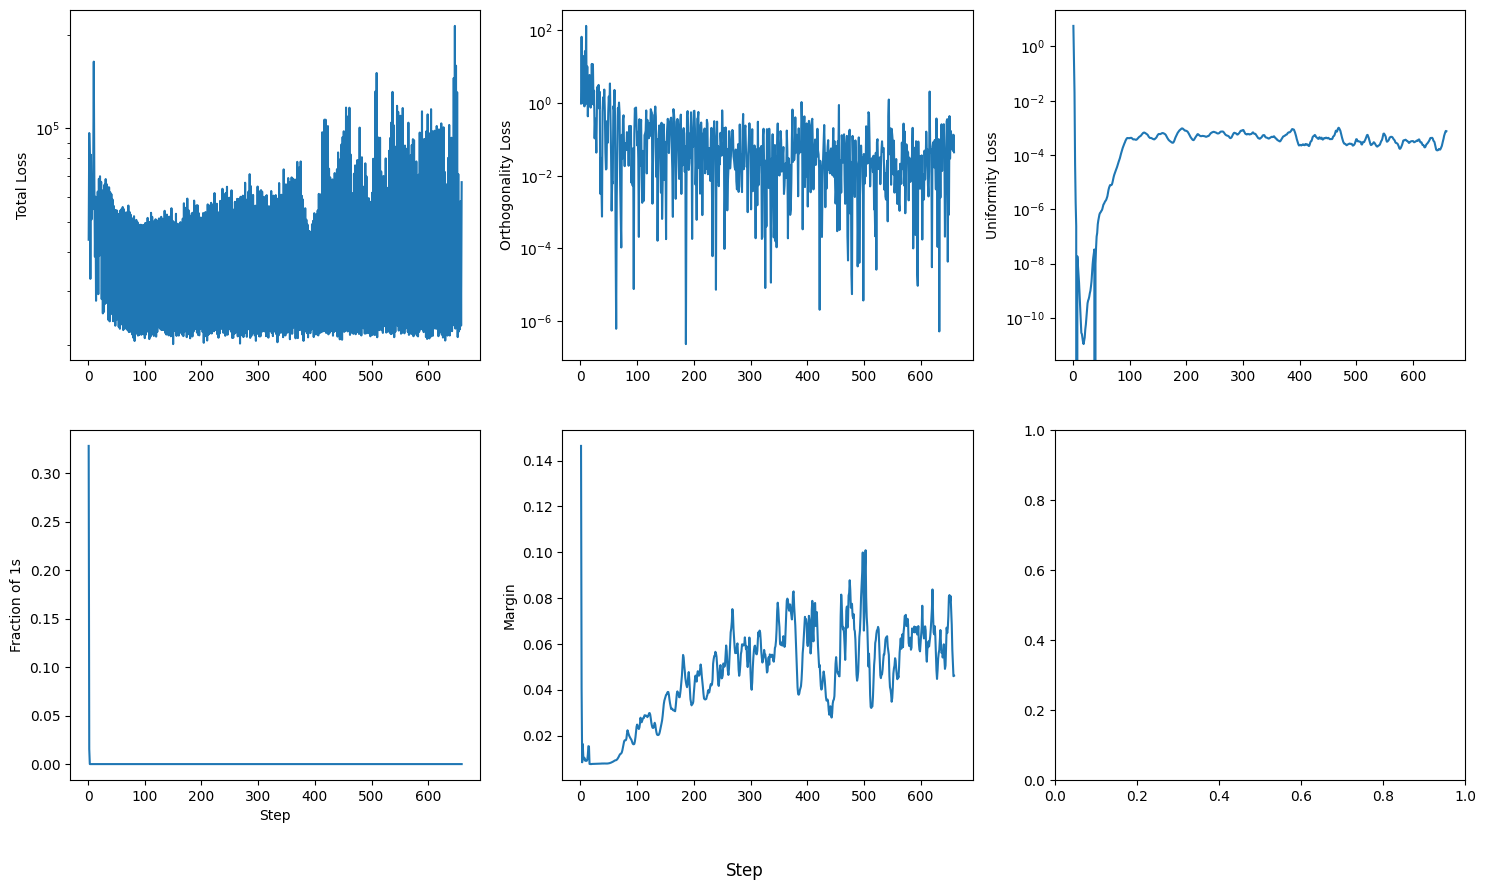

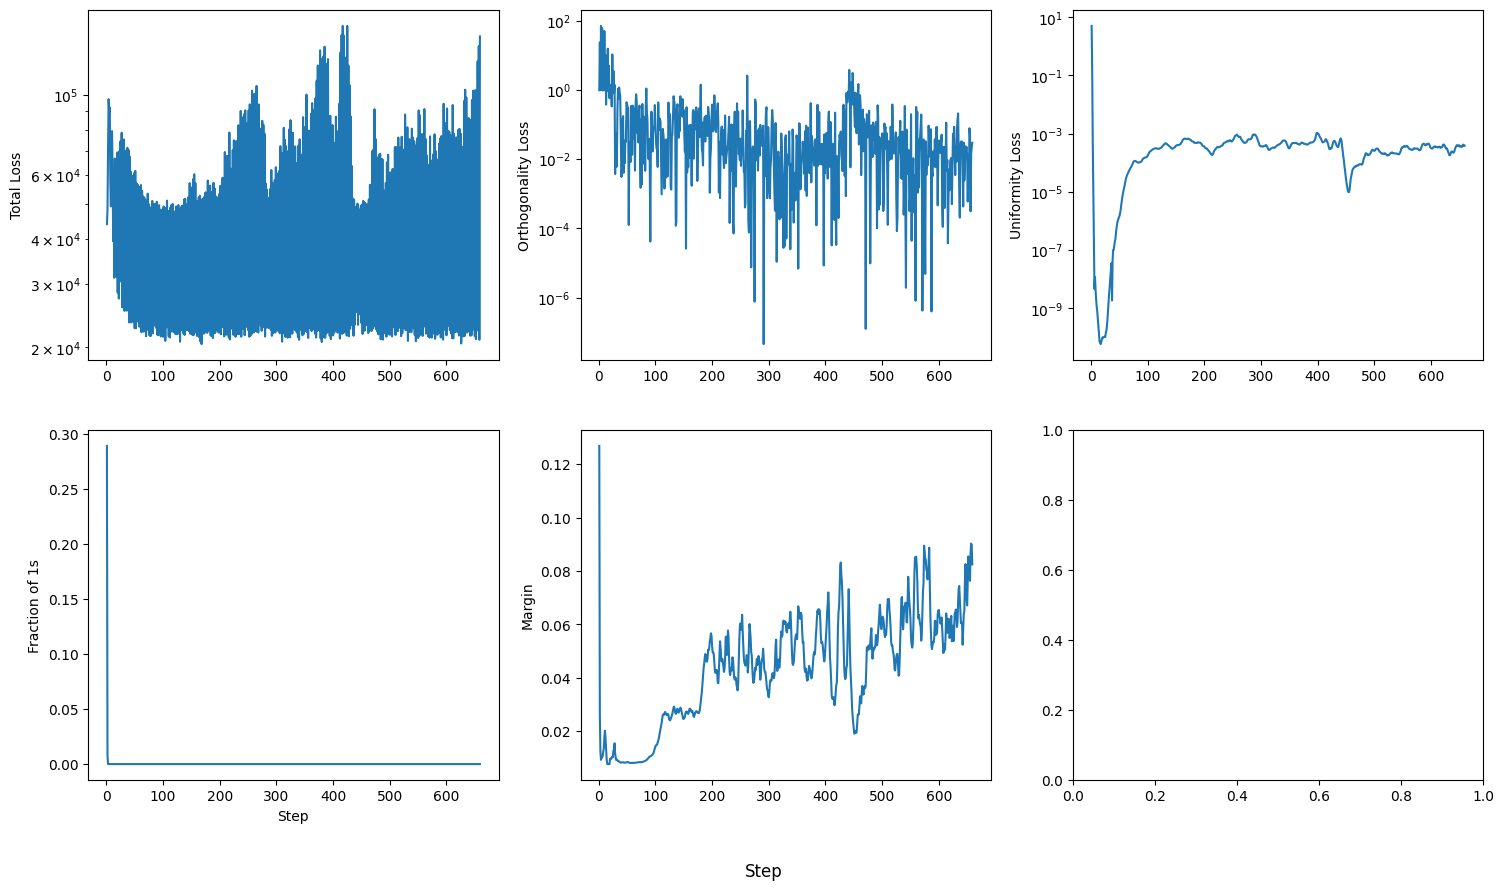

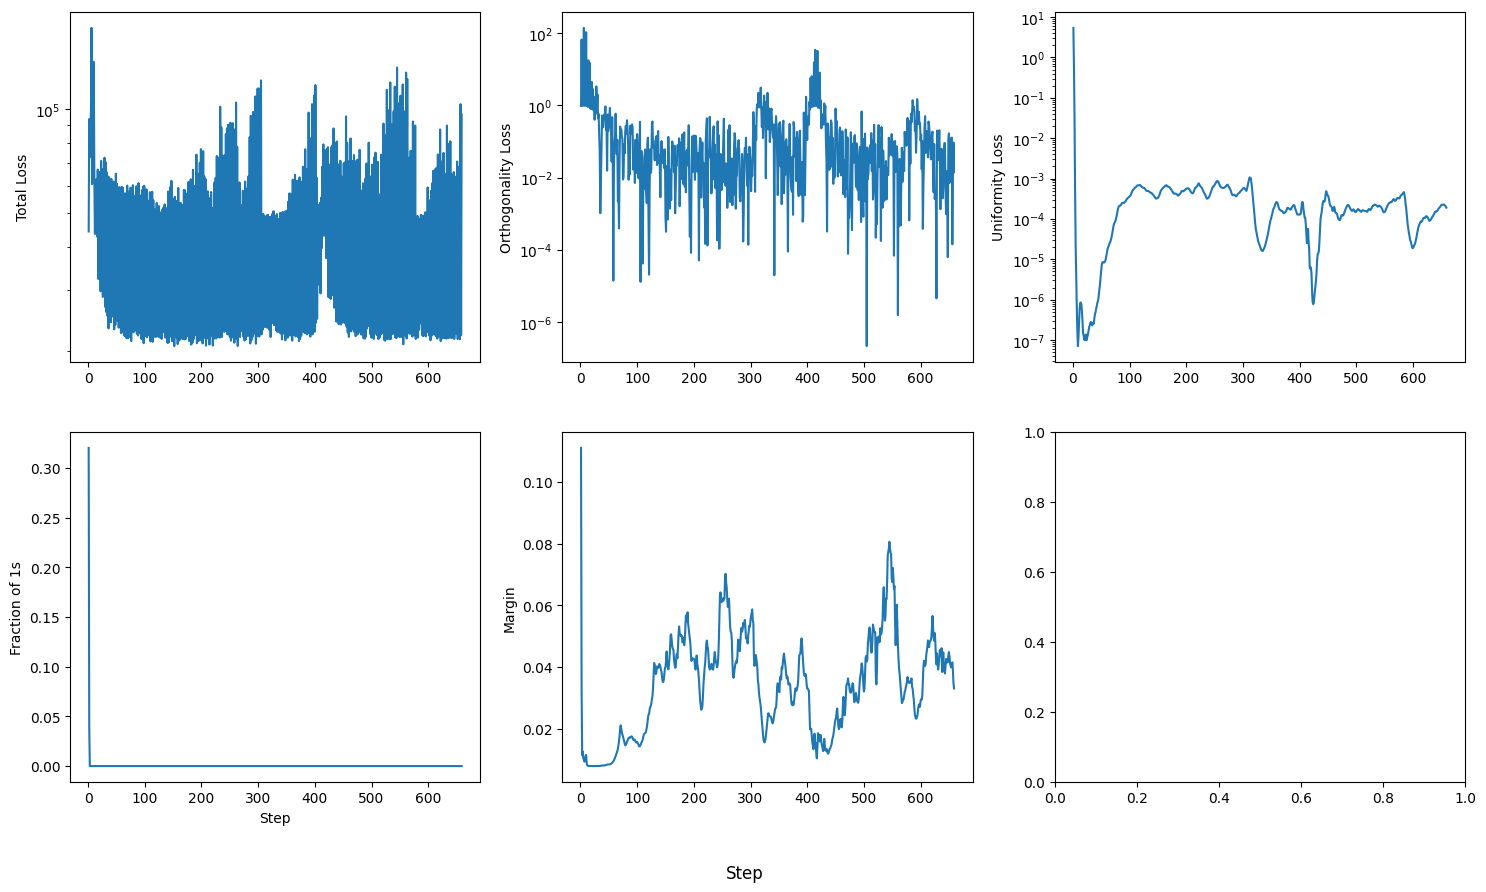

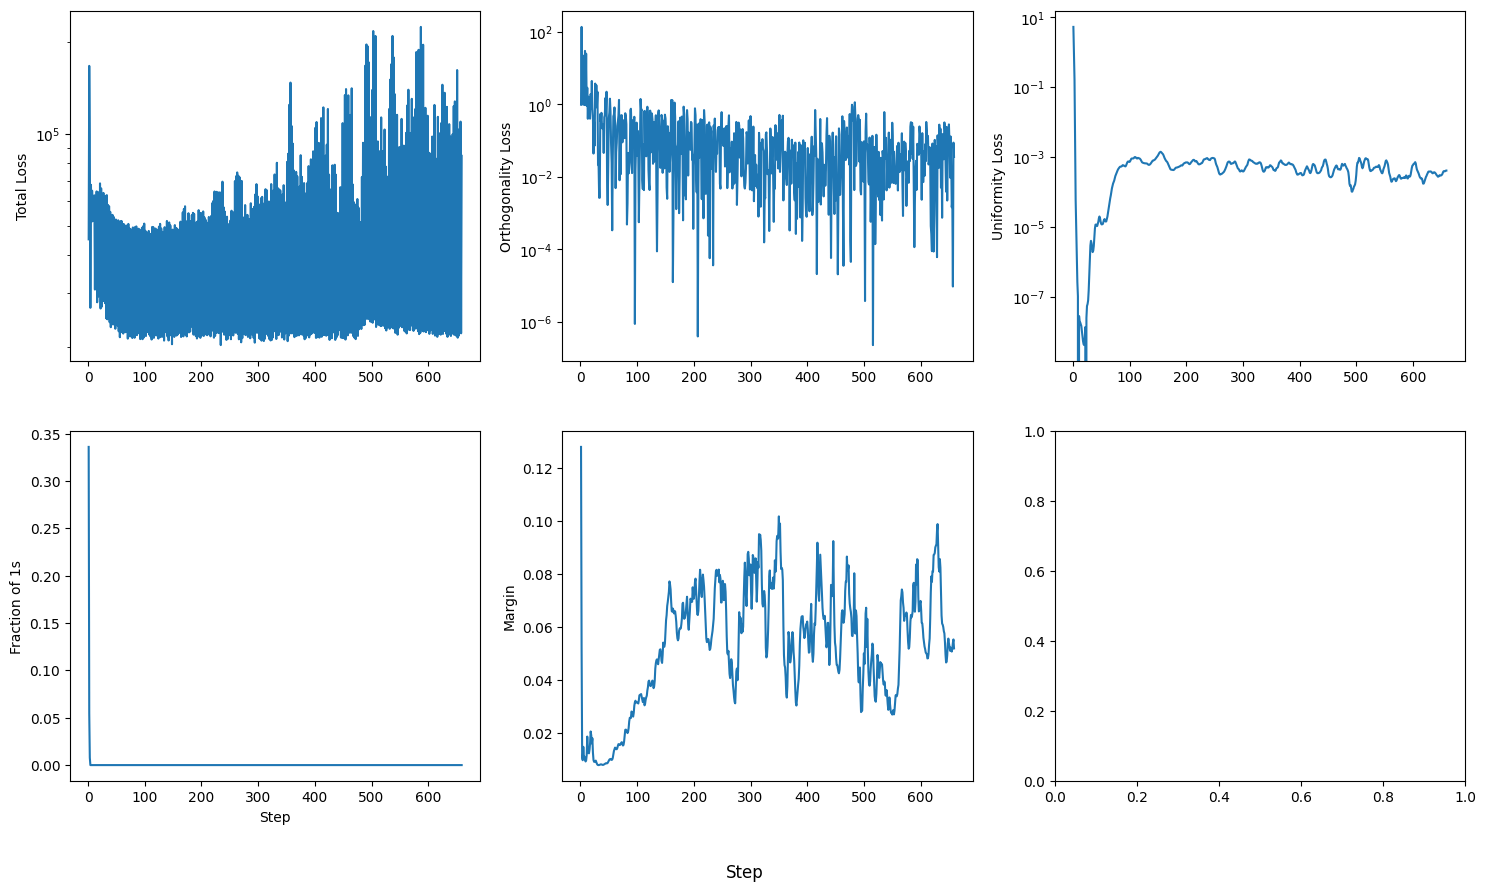

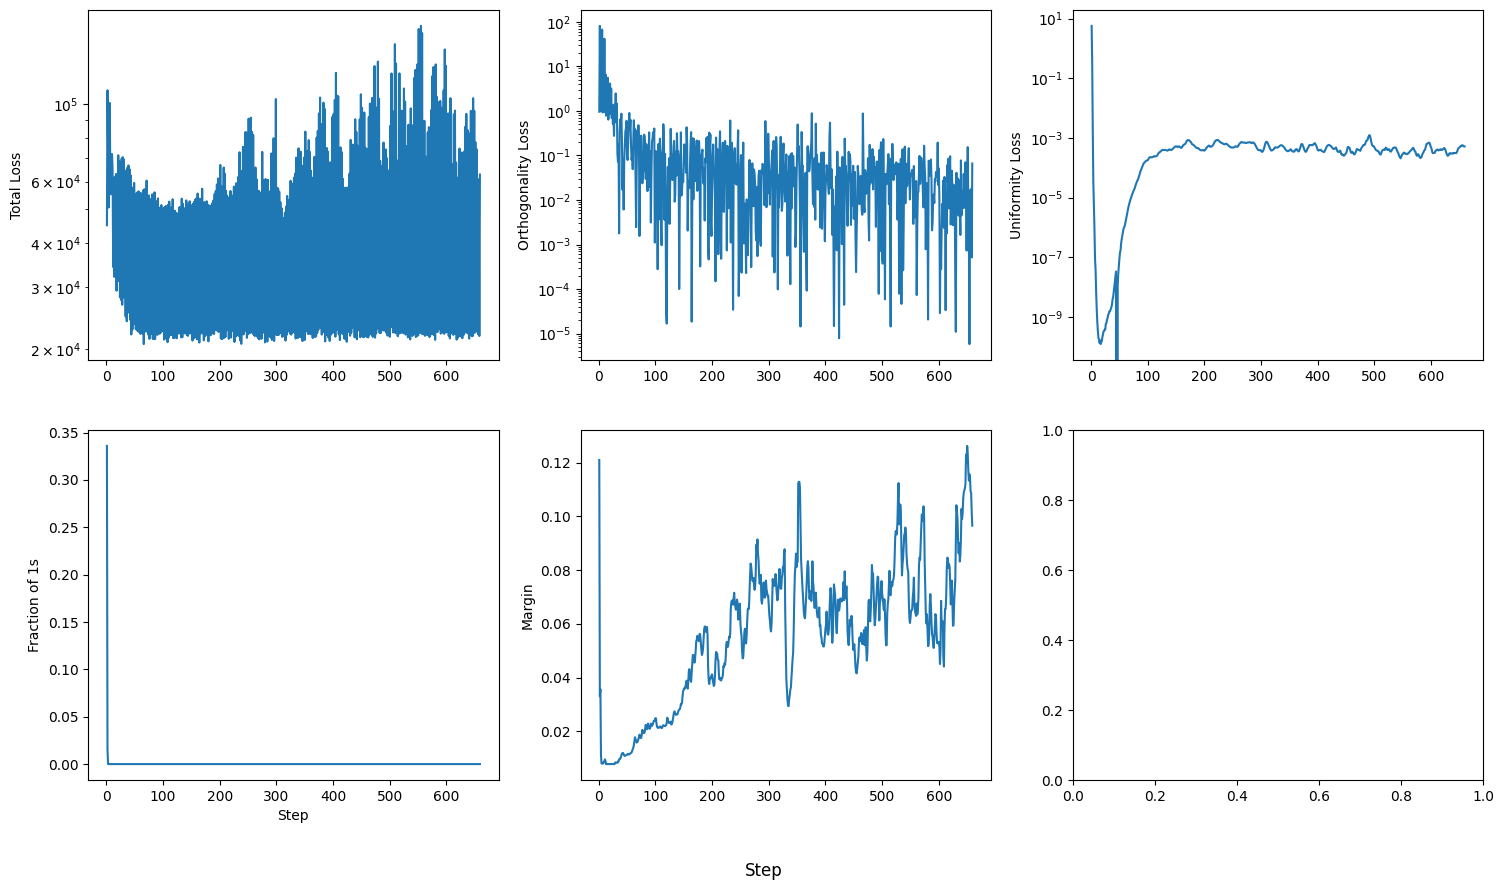

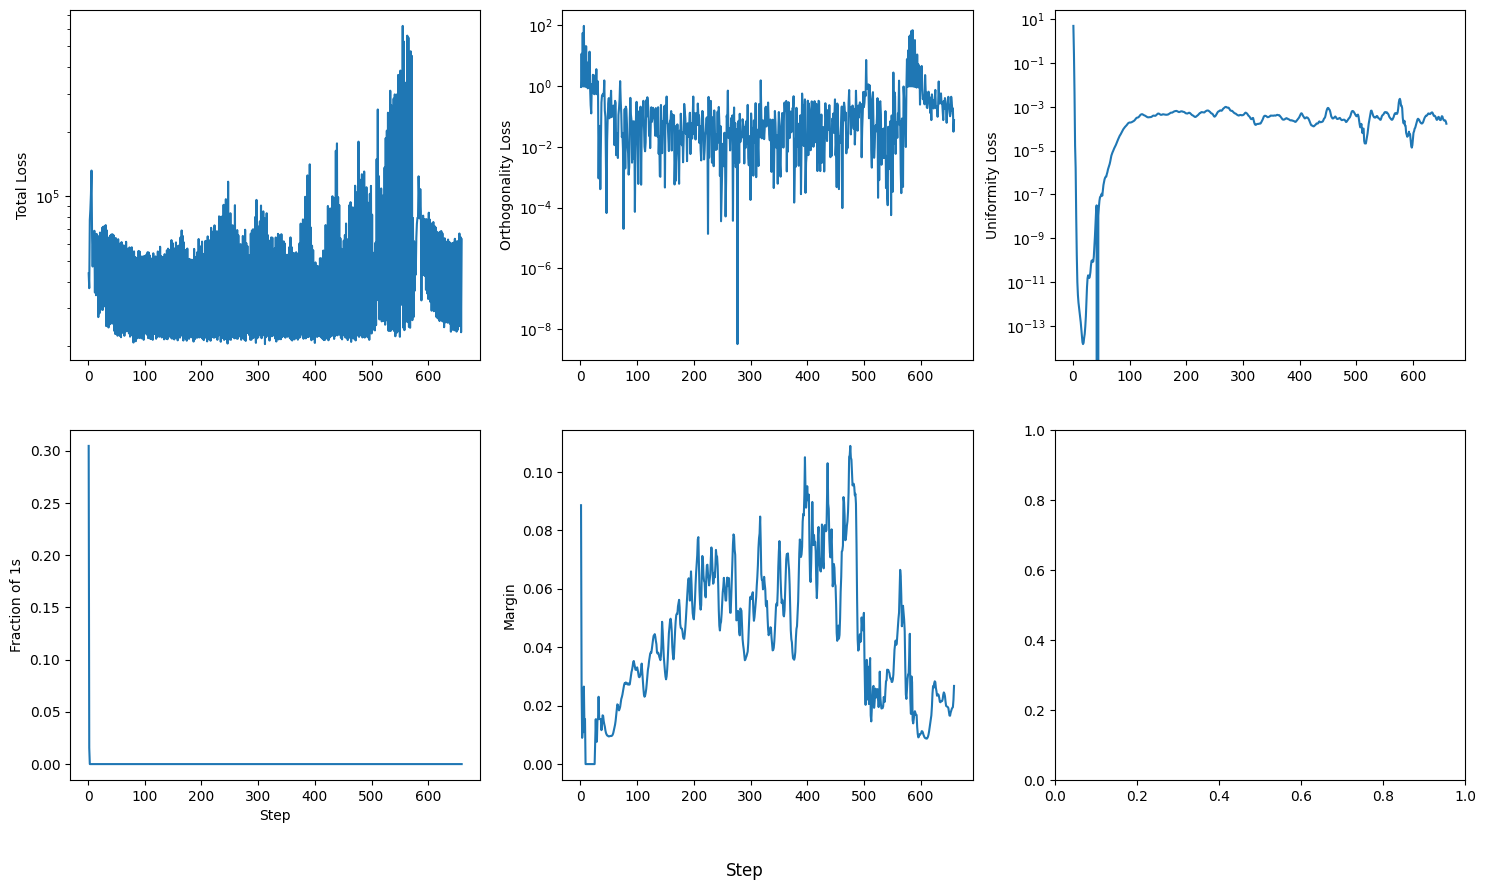

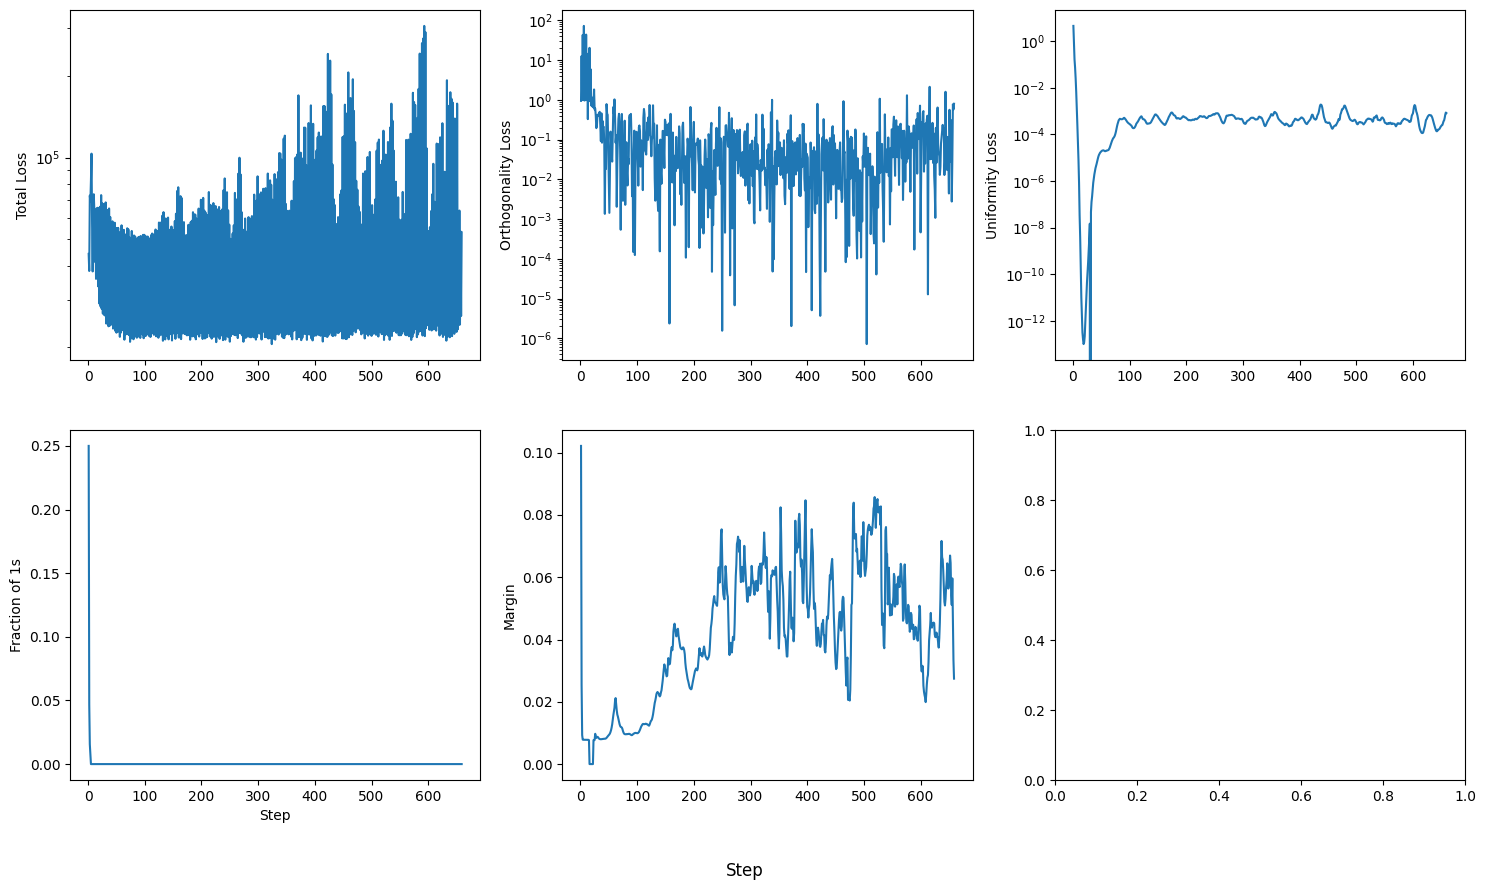

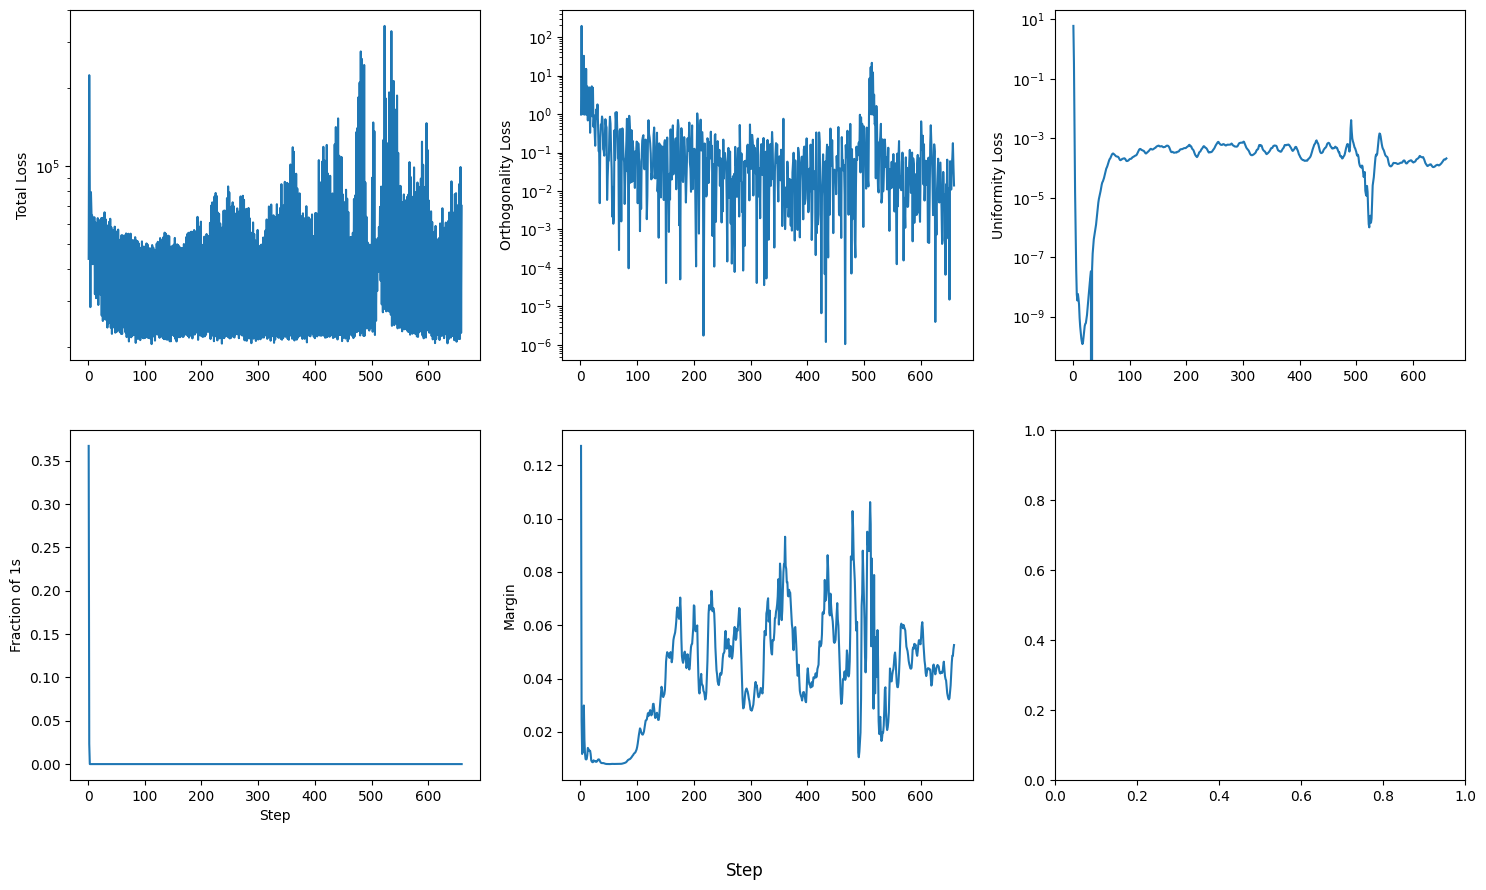

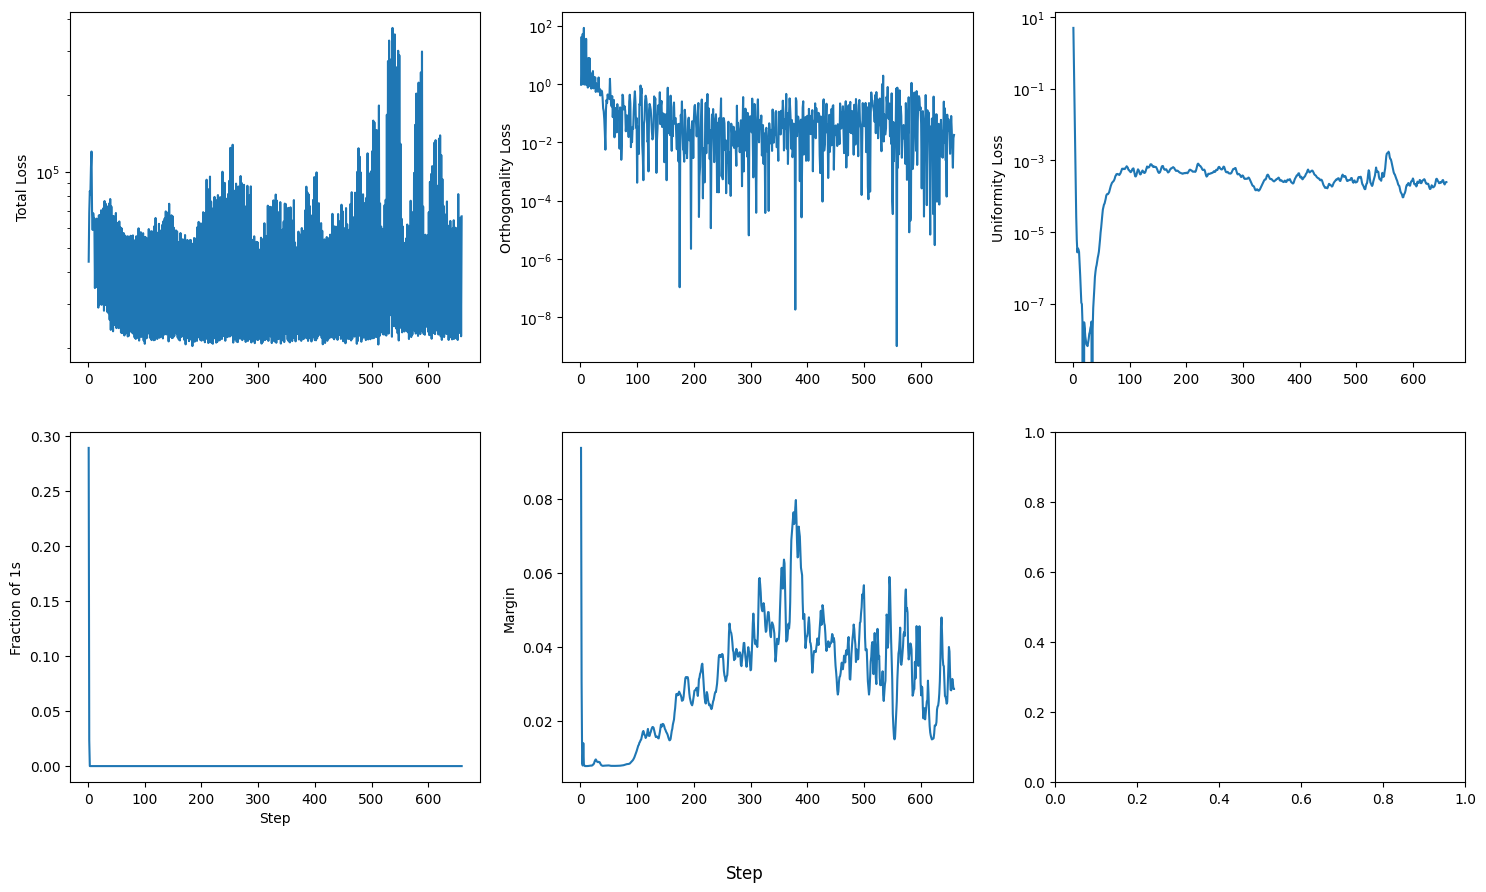

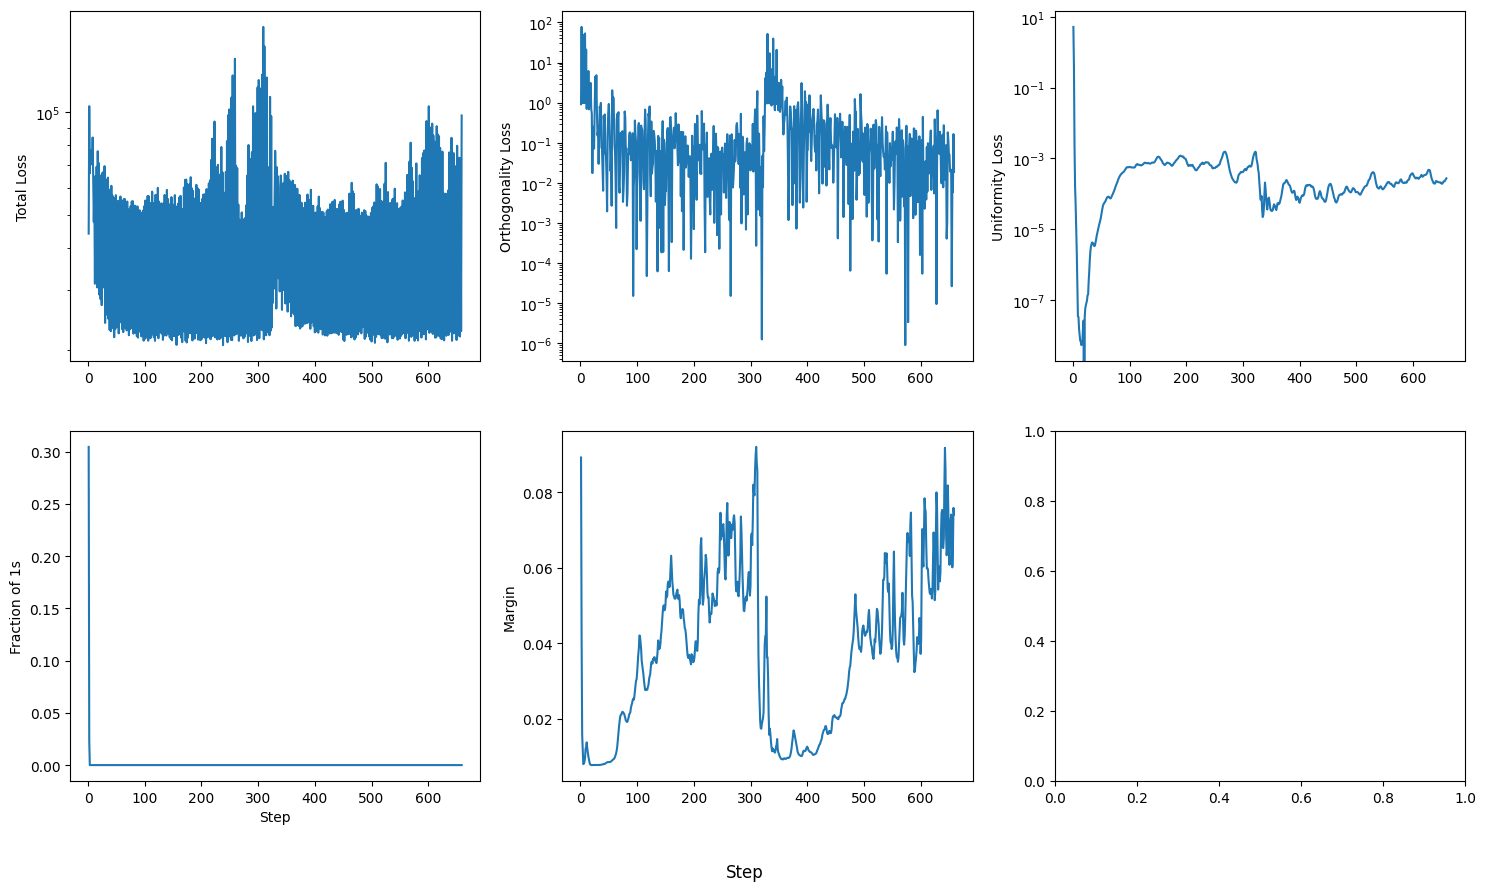

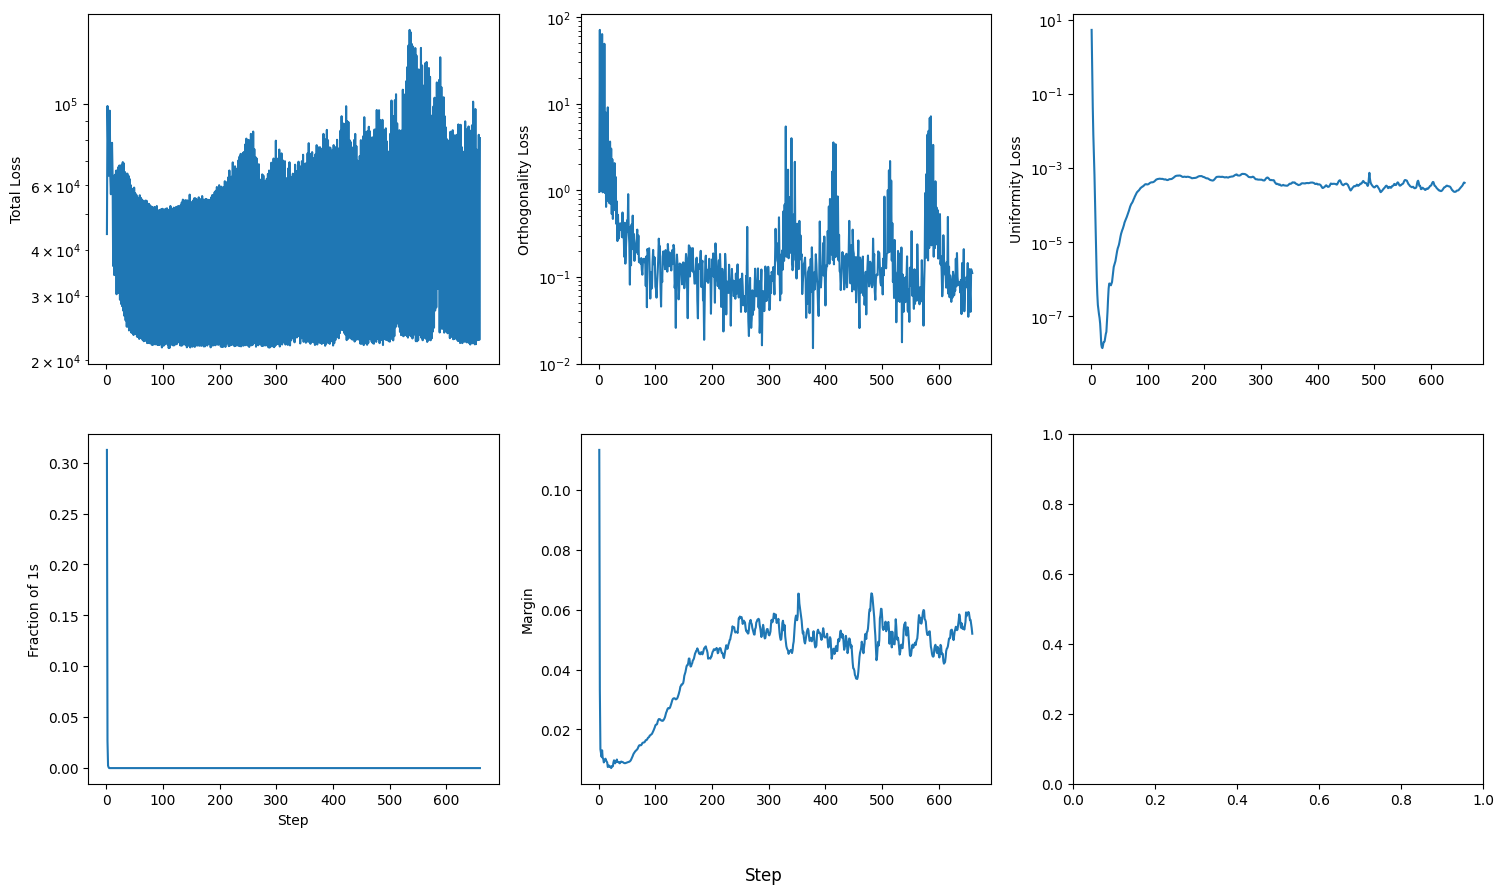

In [ ]:
train_kwargs = params | {"uniformity_weight": 0e3, "orthogonality_weight": 1e3, "forget_weight": 0.}
train_kwargs["folder"] = f"{experiment_folder}/vae-os"
be = bt.BatchExperiment(vos.train, train_kwargs, num_experiments)
be.run()
be.fid(num_fid_samples, device, fid_batch_size)
be.summarize(num_fid_samples=num_fid_samples, batch_size=fid_batch_size)

**Batch Experiments: OhatShat**

In [ ]:
train_kwargs = params | {"uniformity_weight": 1e3, "orthogonality_weight": 1e3, "forget_weight": 0.}
train_kwargs["folder"] = f"{experiment_folder}/vae-ohatshat"
be = bt.BatchExperiment(vos.train, train_kwargs, num_experiments)
be.run()
be.fid(num_fid_samples, device, fid_batch_size)
be.summarize(num_fid_samples=num_fid_samples, batch_size=fid_batch_size)

**Batch Experiments: hat**

Epochs: 100%|██████████| 1/1 [04:44<00:00, 284.92s/it]


Time taken by summarize_training is 1.0104 seconds


Epochs: 100%|██████████| 1/1 [04:48<00:00, 288.13s/it]


Time taken by summarize_training is 1.1823 seconds


Epochs: 100%|██████████| 1/1 [04:44<00:00, 284.83s/it]


Time taken by summarize_training is 1.0142 seconds


Epochs: 100%|██████████| 1/1 [04:46<00:00, 286.42s/it]


Time taken by summarize_training is 1.3103 seconds


Epochs: 100%|██████████| 1/1 [04:46<00:00, 286.75s/it]


Time taken by summarize_training is 0.9238 seconds


Epochs: 100%|██████████| 1/1 [04:46<00:00, 286.23s/it]


Time taken by summarize_training is 1.3317 seconds


Epochs: 100%|██████████| 1/1 [04:46<00:00, 286.36s/it]


Time taken by summarize_training is 0.9587 seconds


Epochs: 100%|██████████| 1/1 [04:45<00:00, 285.78s/it]


Time taken by summarize_training is 0.8677 seconds


Epochs: 100%|██████████| 1/1 [04:48<00:00, 288.24s/it]


Time taken by summarize_training is 0.8497 seconds


Epochs: 100%|██████████| 1/1 [04:49<00:00, 289.15s/it]


Time taken by summarize_training is 0.9132 seconds
Time taken by run is 2898.7859 seconds


Downloading: "https://download.pytorch.org/models/inception_v3_google-0cc3c7bd.pth" to /root/.cache/torch/hub/checkpoints/inception_v3_google-0cc3c7bd.pth
100%|██████████| 104M/104M [00:00<00:00, 196MB/s] 


Time taken by compute_fid_from_folder is 24.0045 seconds
Time taken by compute_fid_from_folder is 23.3492 seconds
Time taken by compute_fid_from_folder is 23.3560 seconds
Time taken by compute_fid_from_folder is 23.6163 seconds
Time taken by compute_fid_from_folder is 23.2894 seconds
Time taken by compute_fid_from_folder is 23.3473 seconds
Time taken by compute_fid_from_folder is 23.3084 seconds
Time taken by compute_fid_from_folder is 23.3484 seconds
Time taken by compute_fid_from_folder is 23.2906 seconds
Time taken by compute_fid_from_folder is 23.3513 seconds
Time taken by fid is 258.2715 seconds


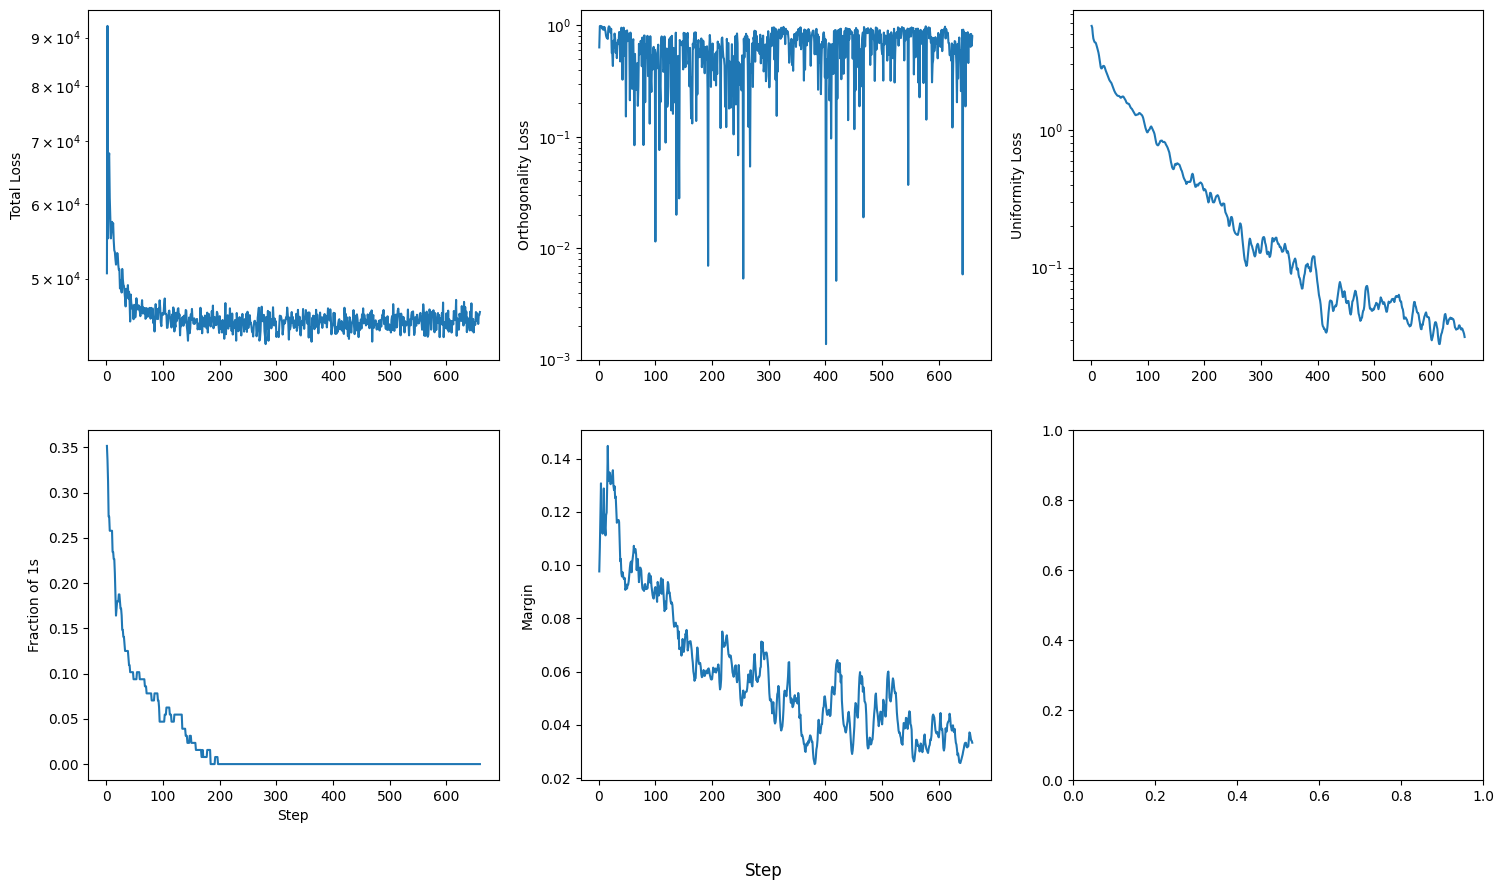

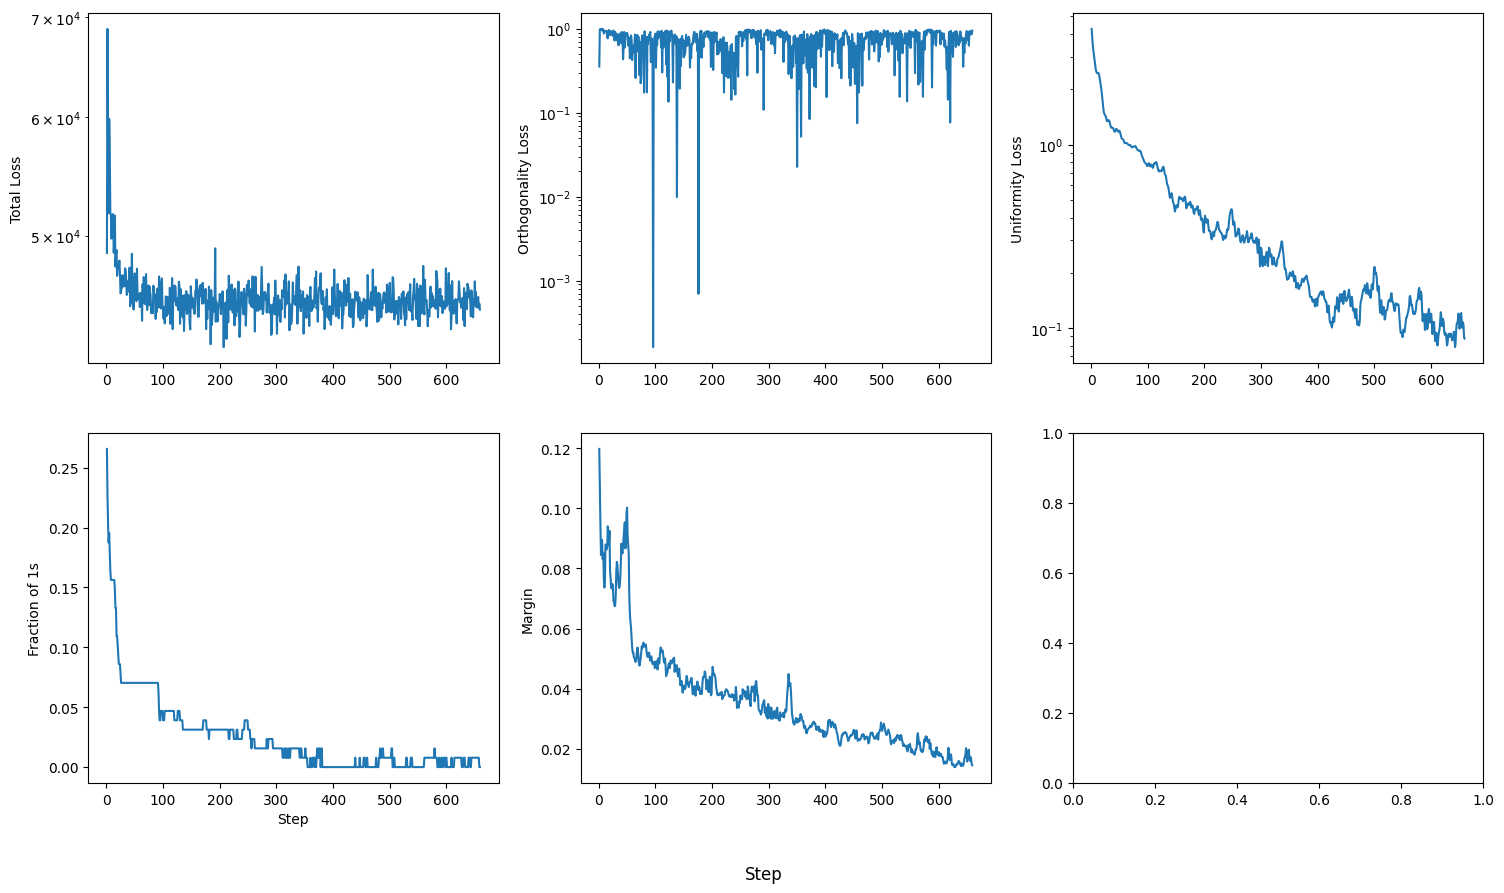

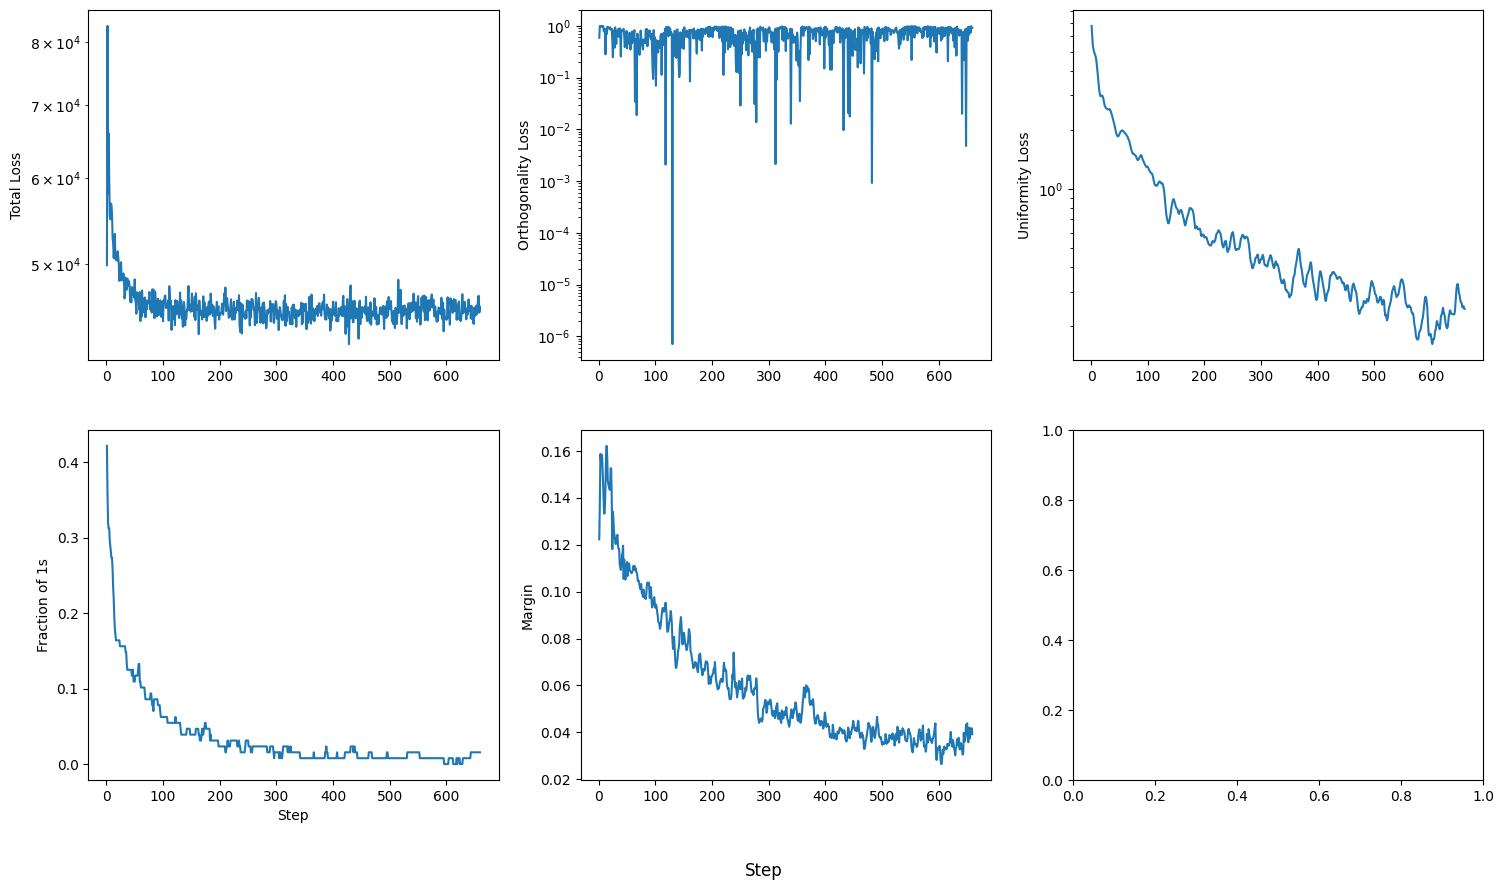

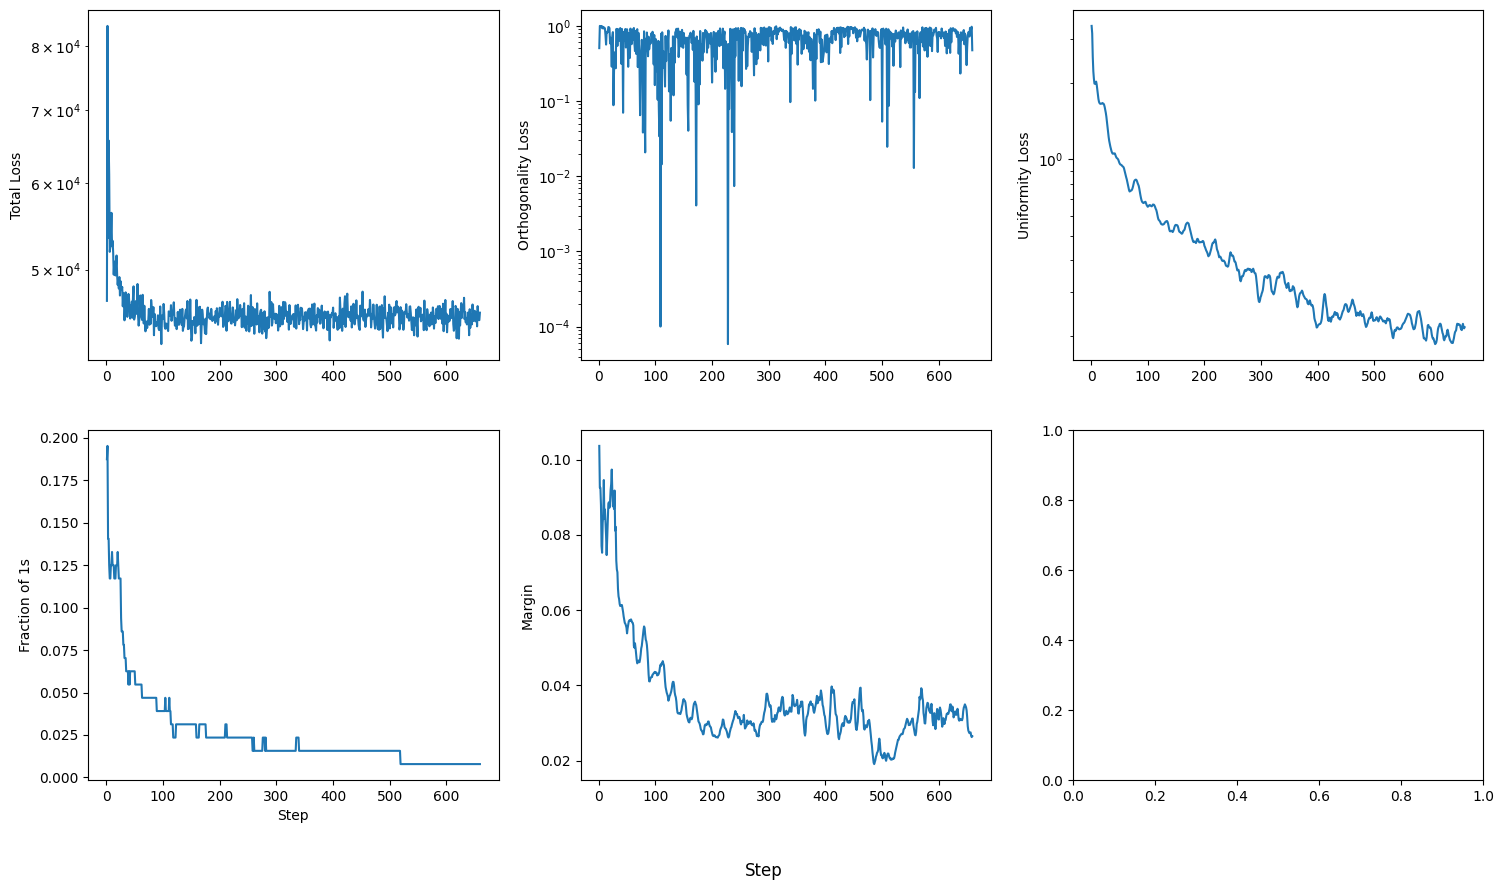

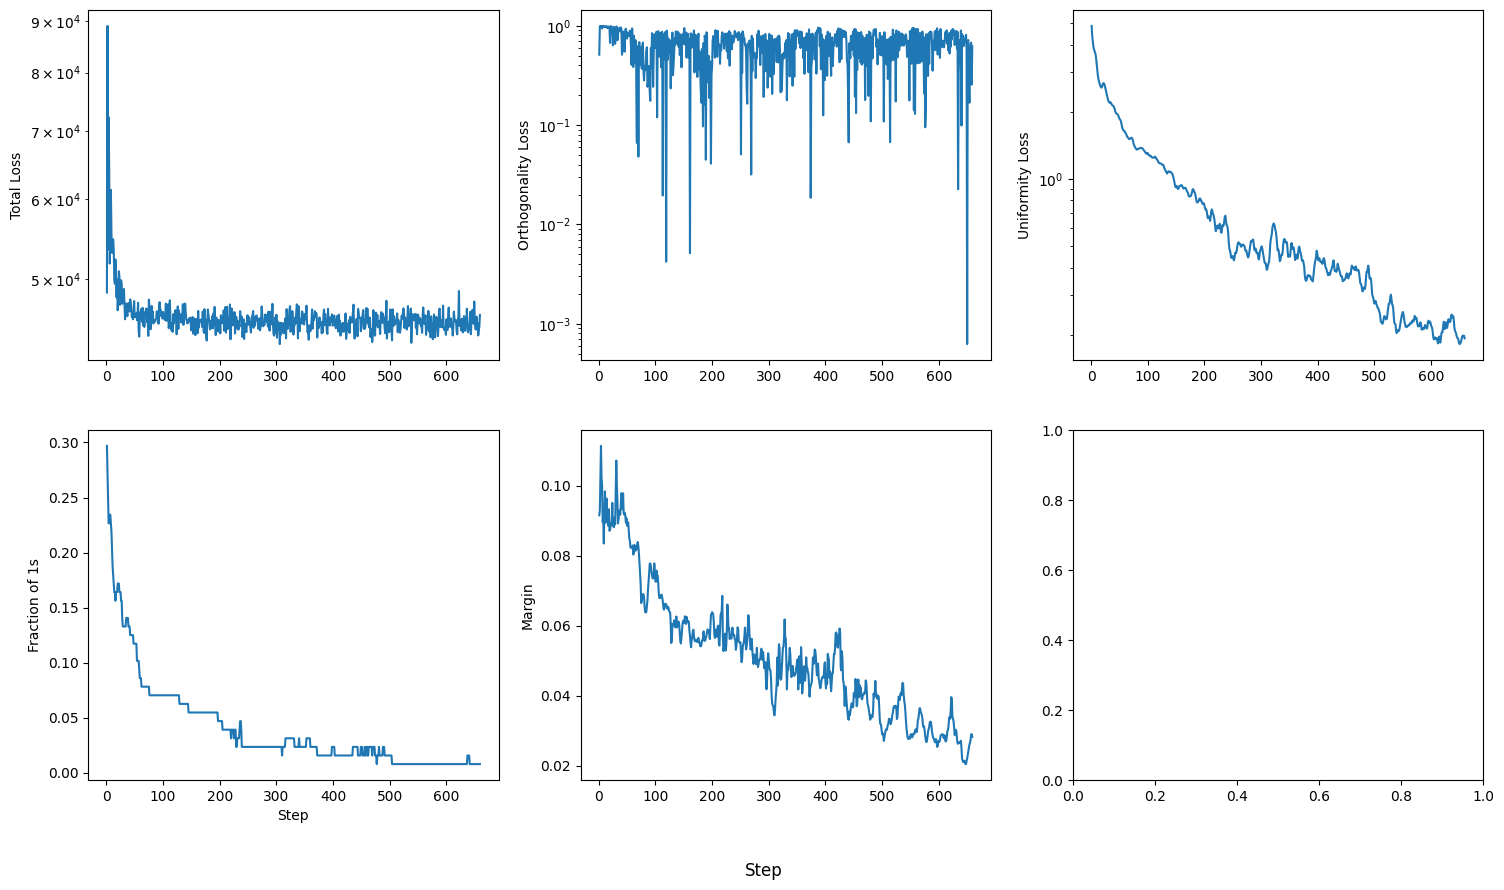

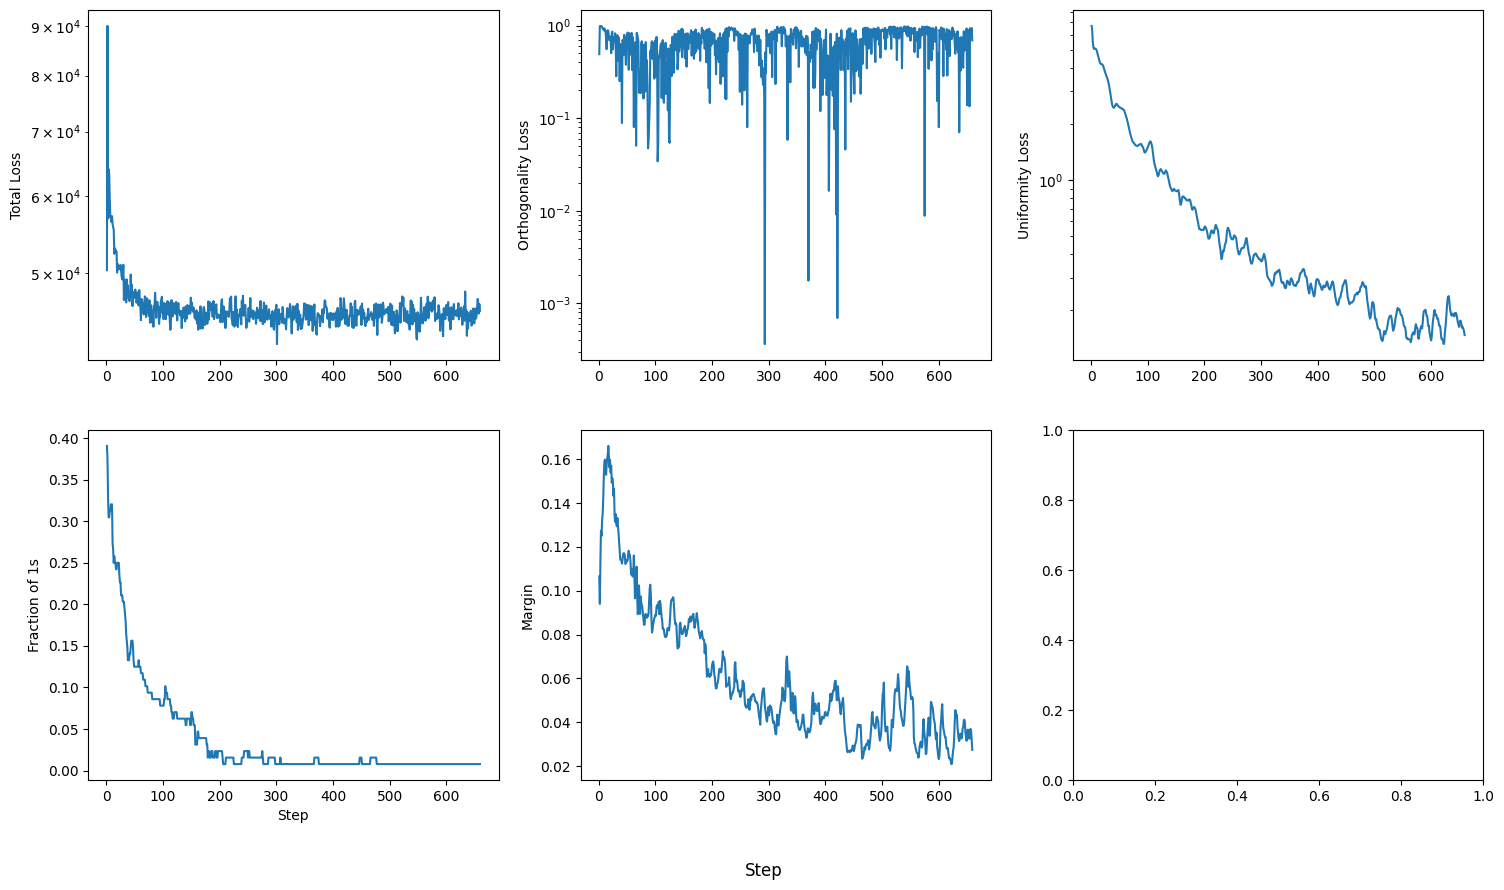

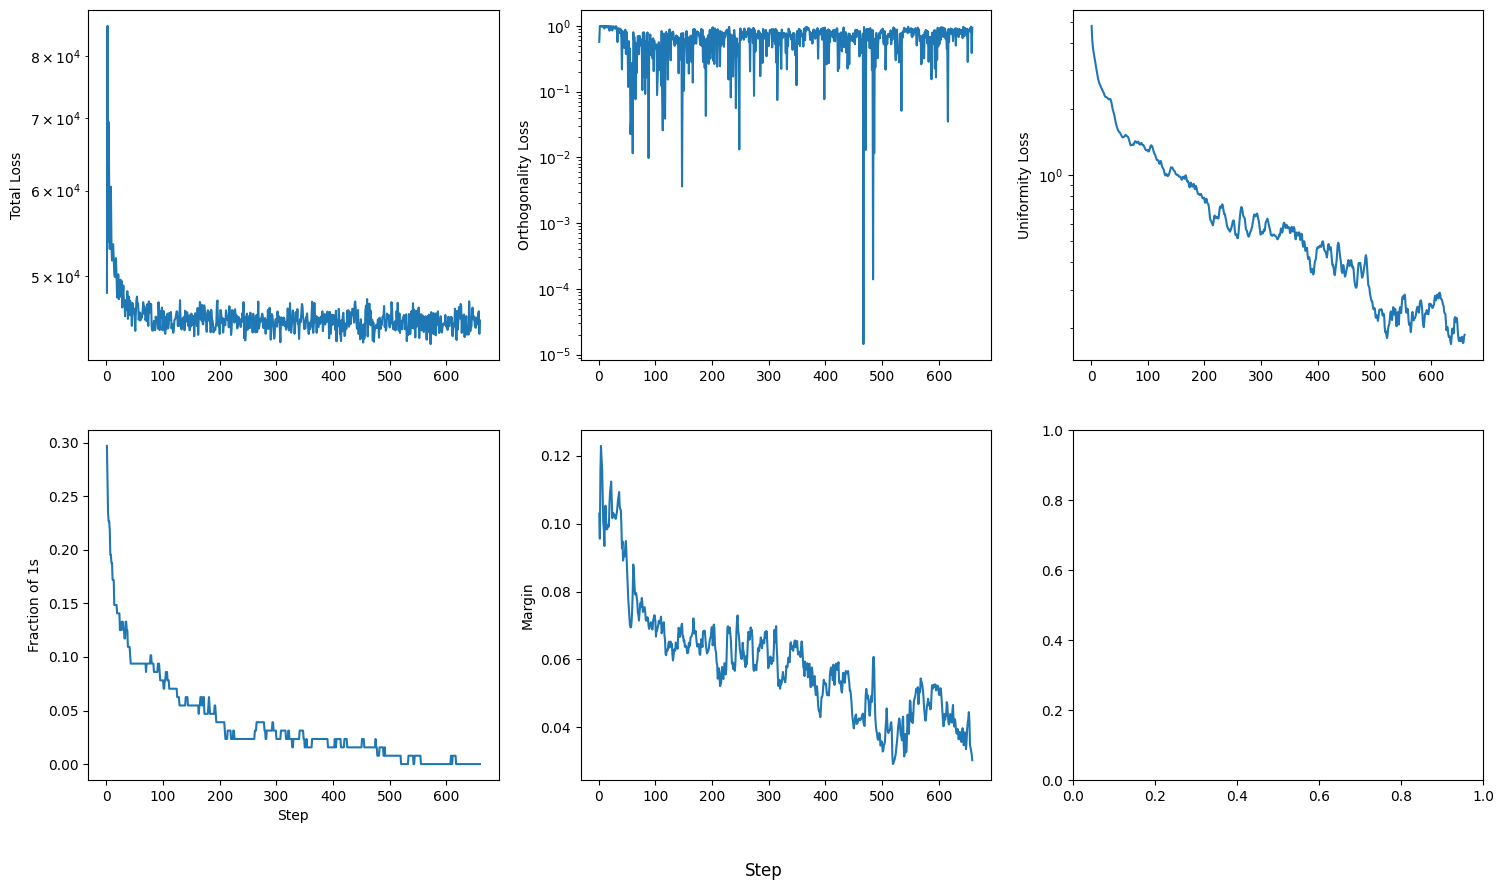

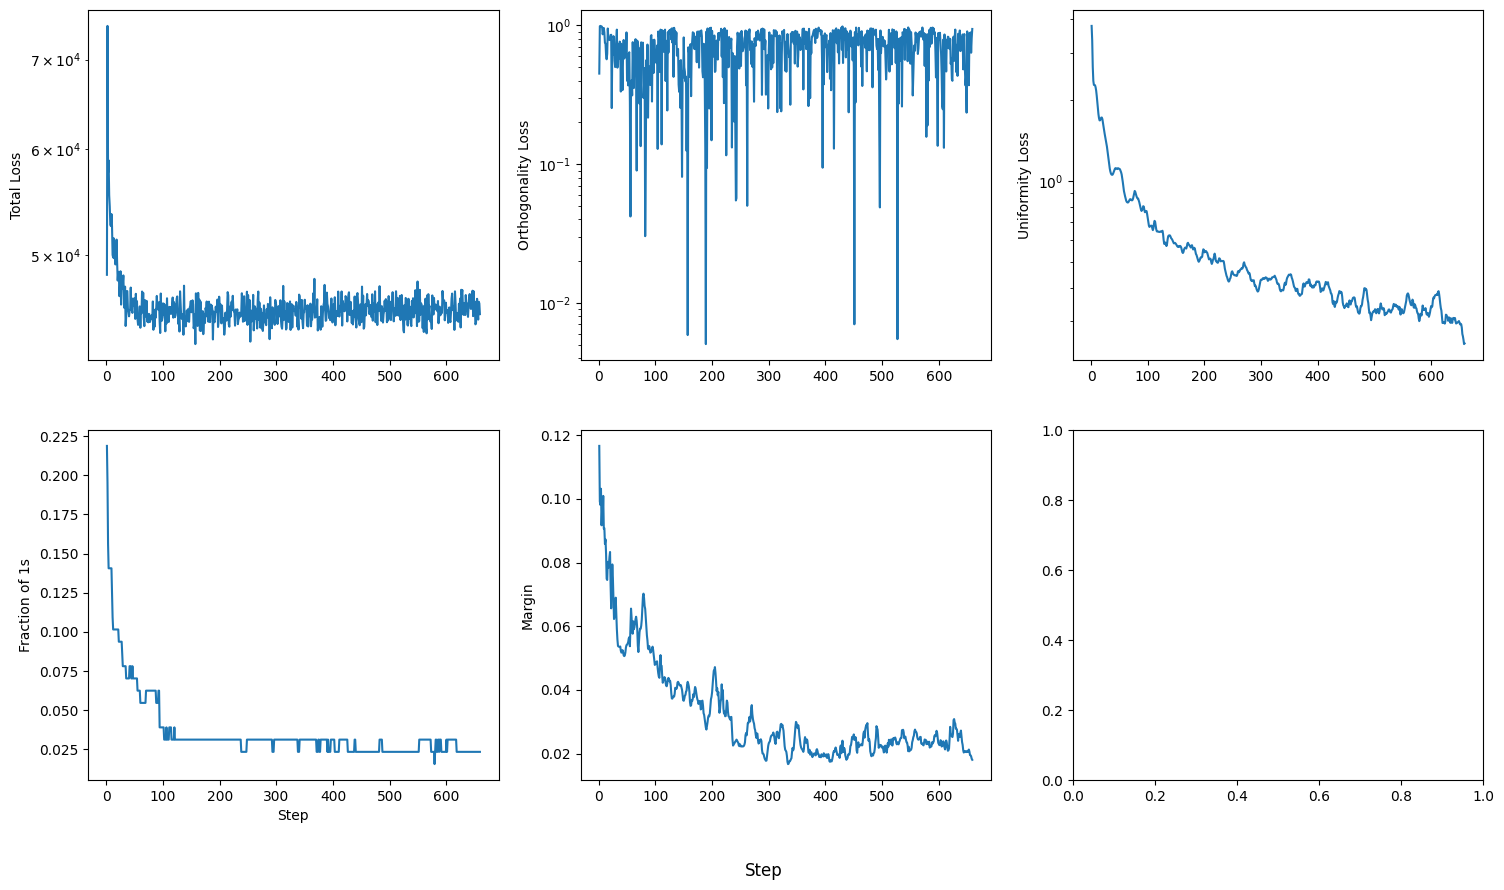

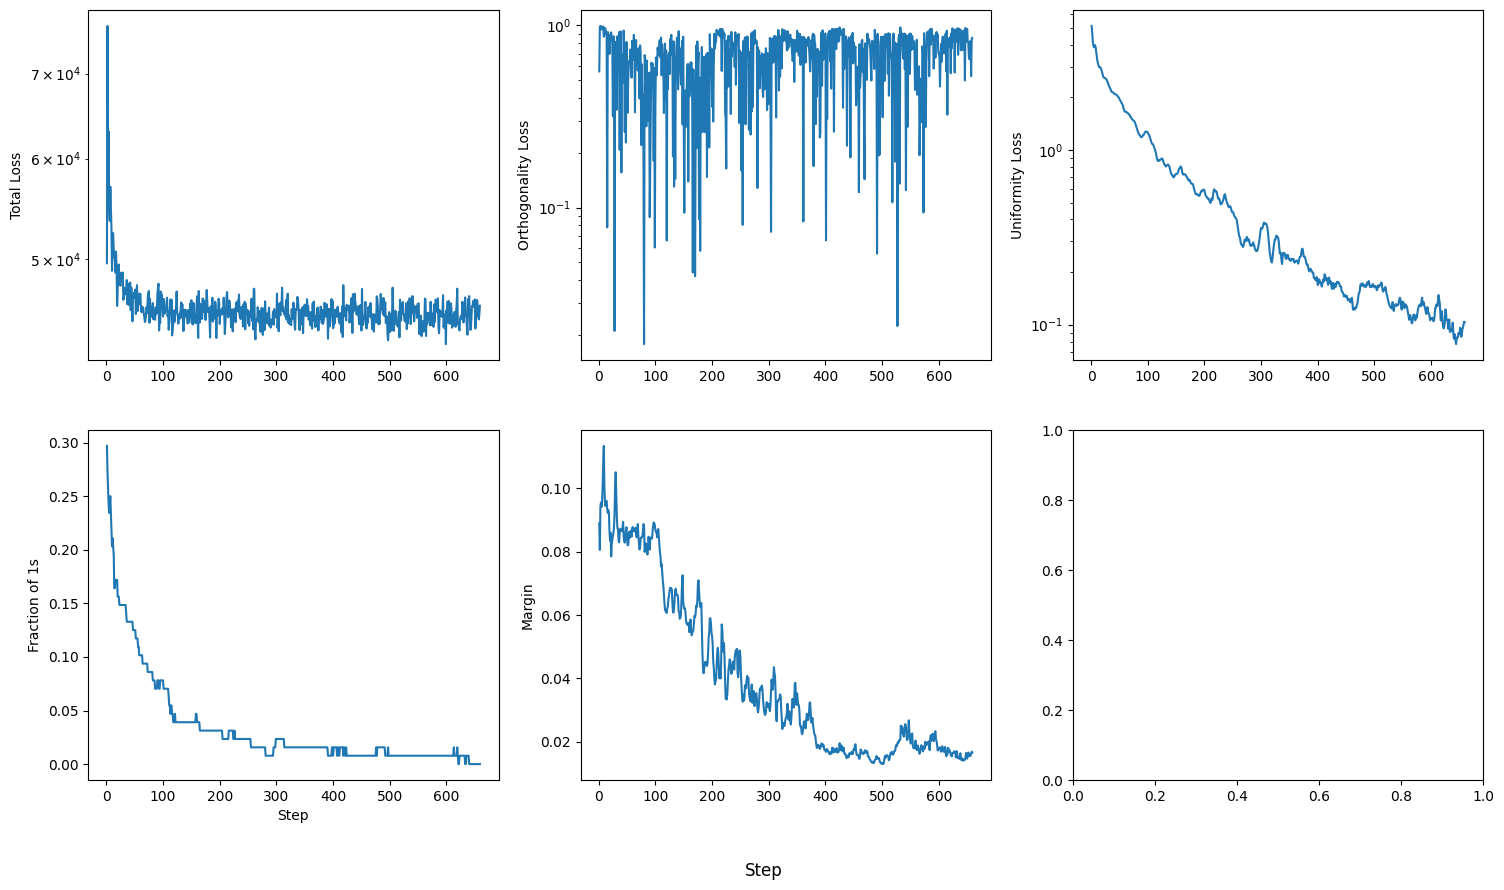

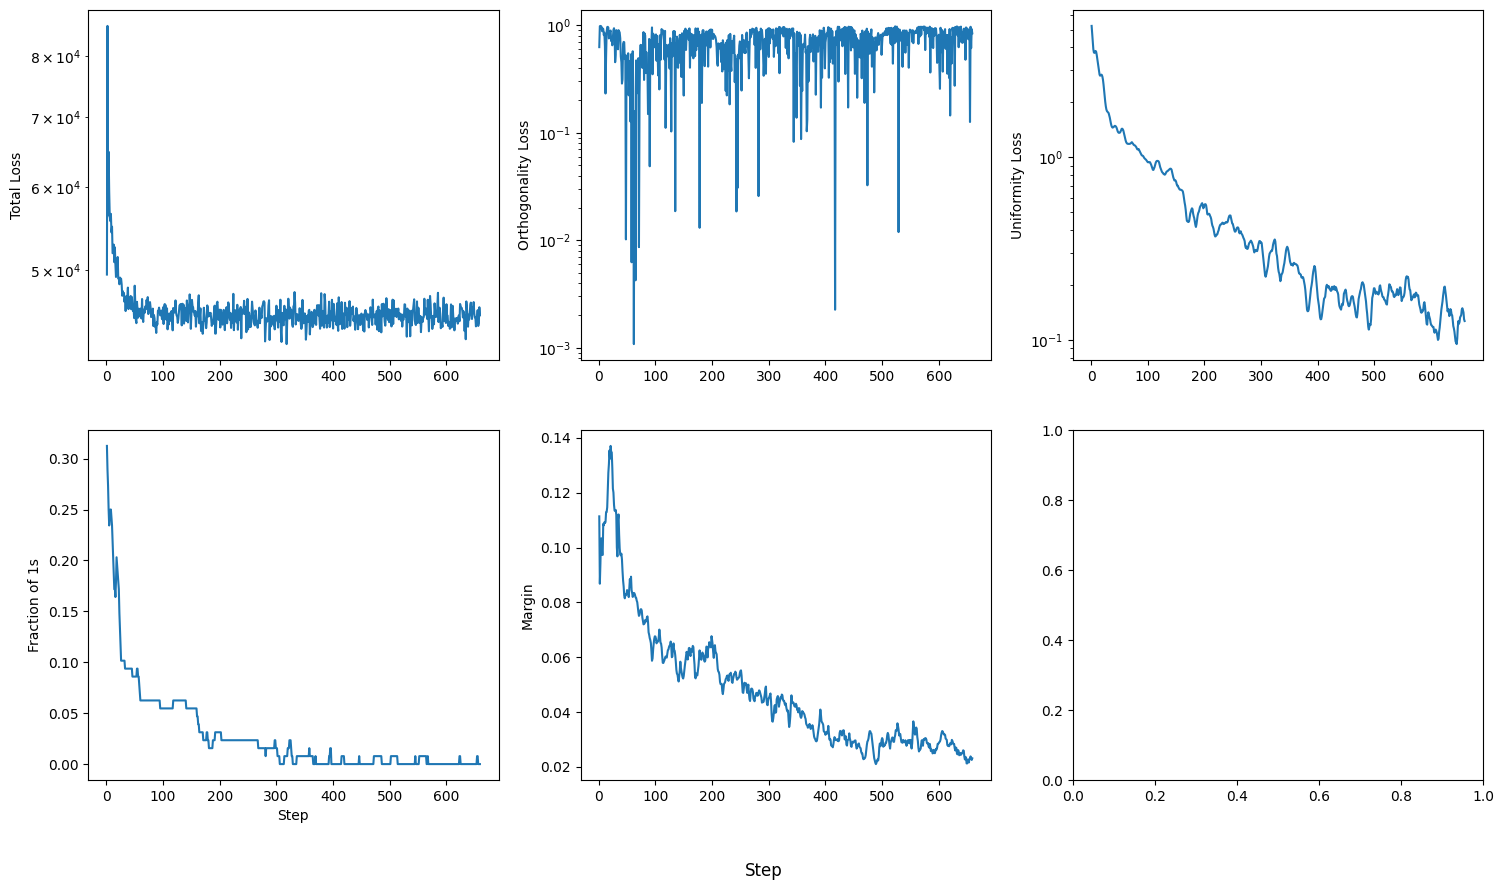

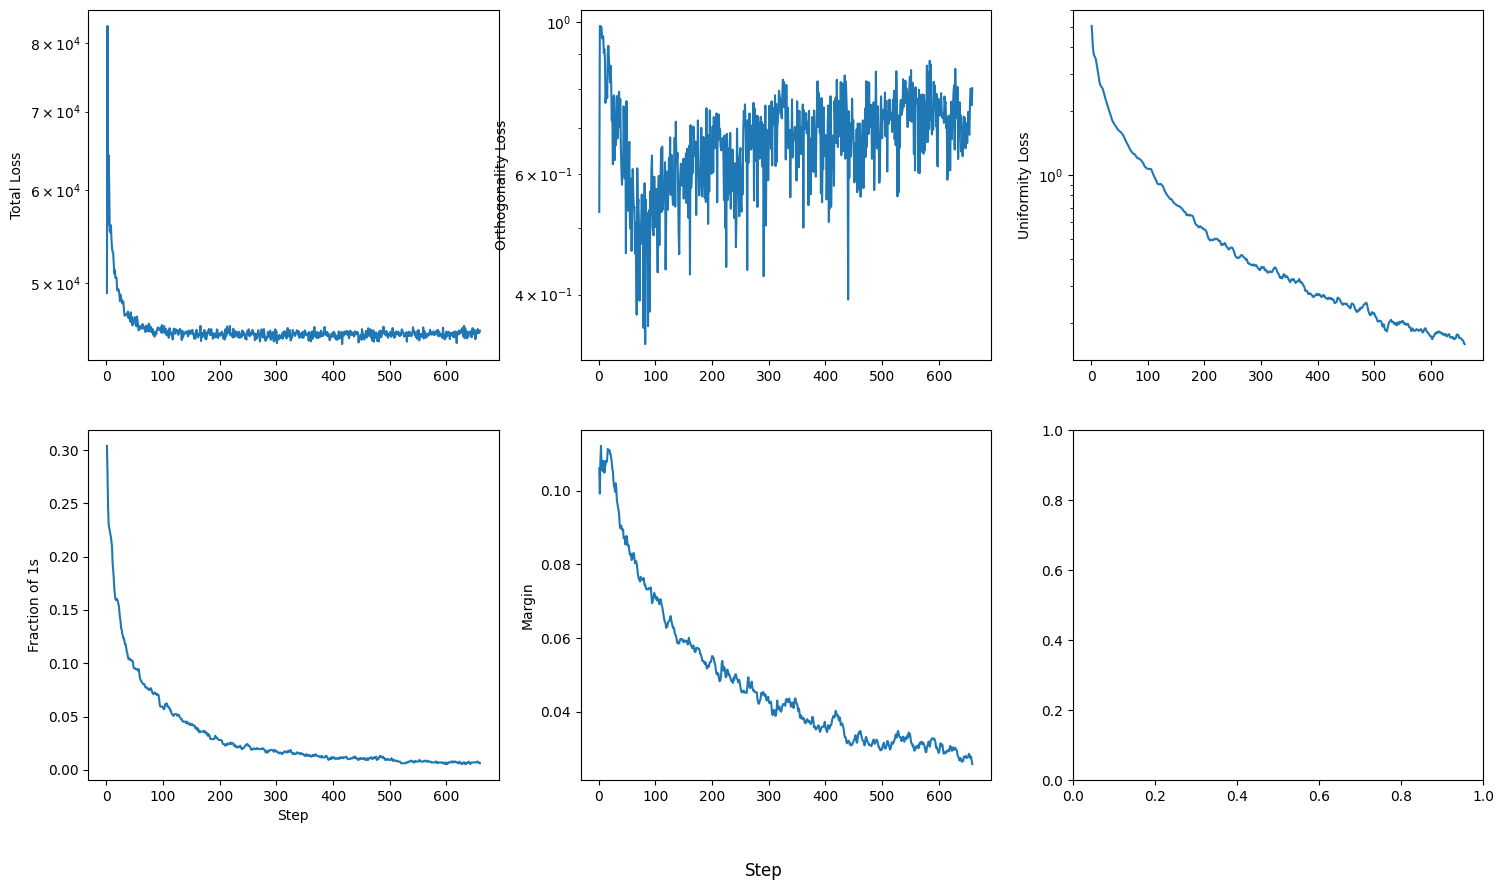

In [ ]:
import vae_hat as vh
train_kwargs = params | {"num_steps": 500, "uniformity_weight": 1e3, "orthogonality_weight": 0e3, "forget_weight": 0.}
train_kwargs["folder"] = f"{experiment_folder}/vae-hat"
be = bt.BatchExperiment(vh.train, train_kwargs, num_experiments)
be.run()
be.fid(num_fid_samples, device, fid_batch_size)
be.summarize(num_fid_samples=num_fid_samples, batch_size=fid_batch_size)

**Upload data to Drive**

In [ ]:
!zip -r /content/CelebA-Experiments-r-1.zip /content/CelebA-Experiments
!cp /content/CelebA-Experiments-r-1.zip "/content/drive/MyDrive/Pinak/forget"

  adding: content/CelebA-Experiments/ (stored 0%)
  adding: content/CelebA-Experiments/vae-ohatshat/ (stored 0%)
  adding: content/CelebA-Experiments/vae-ohatshat/expr-0/ (stored 0%)
  adding: content/CelebA-Experiments/vae-ohatshat/expr-0/checkpoints/ (stored 0%)
  adding: content/CelebA-Experiments/vae-ohatshat/expr-0/checkpoints/training_log.csv (deflated 24%)
  adding: content/CelebA-Experiments/vae-ohatshat/expr-0/config.json (deflated 75%)
  adding: content/CelebA-Experiments/vae-ohatshat/expr-0/samples/ (stored 0%)
  adding: content/CelebA-Experiments/vae-hat/ (stored 0%)
  adding: content/CelebA-Experiments/vae-hat/expr-1/ (stored 0%)
  adding: content/CelebA-Experiments/vae-hat/expr-1/checkpoints/ (stored 0%)
  adding: content/CelebA-Experiments/vae-hat/expr-1/checkpoints/training_log.csv (deflated 58%)
  adding: content/CelebA-Experiments/vae-hat/expr-1/checkpoints/vae_epoch_1.pth (deflated 7%)
  adding: content/CelebA-Experiments/vae-hat/expr-1/config.json (deflated 75%)
  a